# NBA Analyzer

### Description

I found this really cool NBA dataset API and I kinda figured that since I have some free time that Ill throw some datascience skills in it and see what I can find out.




### RESOURCES:
- https://towardsdatascience.com/anomaly-detection-in-python-part-2-multivariate-unsupervised-methods-and-code-b311a63f298b
- https://scikit-learn.org/0.20/auto_examples/plot_anomaly_comparison.html



We can start by importing all packages that will be used for this project as well as any necessary preparations such as printing all columns for effective work

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import ensemble
from sklearn.ensemble import IsolationForest
from sklearn import svm
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from scipy import stats
import math

# -----------------------------------------------
ds = pd.read_csv('players.csv')  
print(ds.columns)
ds.describe()

Index(['Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'],
      dtype='object')


,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
count,529.000000,529.000000,529.000000,529.000000,529.000000,529.000000,527.000000,529.000000,529.000000,502.000000,...,504.000000,529.000000,529.000000,529.000000,529.000000,529.000000,529.000000,529.000000,529.000000,529.000000
mean,25.561437,42.330813,20.018904,19.513043,3.202457,7.047259,0.446750,0.941588,2.698866,0.312365,...,0.743476,0.837618,2.796975,3.632703,1.923629,0.621928,0.399055,1.124386,1.753875,8.726465
std,4.119487,22.633322,24.238548,9.210213,2.272950,4.758302,0.106226,0.856907,2.215629,0.130989,...,0.144559,0.748181,1.874912,2.480967,1.762539,0.402797,0.411873,0.821348,0.819685,6.367973
min,19.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.000000,22.000000,0.000000,12.000000,1.400000,3.400000,0.401000,0.300000,0.900000,0.273500,...,0.667000,0.300000,1.500000,1.900000,0.800000,0.300000,0.100000,0.600000,1.200000,3.900000
50%,25.000000,48.000000,6.000000,18.900000,2.700000,5.800000,0.440000,0.800000,2.300000,0.339500,...,0.769000,0.600000,2.400000,3.200000,1.400000,0.600000,0.300000,0.900000,1.800000,7.000000
75%,28.000000,62.000000,39.000000,27.800000,4.400000,9.700000,0.488000,1.400000,3.800000,0.378000,...,0.833000,1.100000,3.700000,4.700000,2.400000,0.900000,0.500000,1.400000,2.300000,11.900000
max,43.000000,74.000000,73.000000,37.500000,10.900000,22.900000,1.000000,4.400000,12.400000,1.000000,...,1.000000,4.400000,11.400000,15.200000,10.200000,2.100000,2.900000,4.800000,5.000000,34.300000


We'll go ahead and prepare our dataset a bit more. Let's get rid of NaN values within our dataset by equivalating them to the mean of the set.

In [3]:
for i in ds.columns:
    try:
        ds[i].fillna(value=ds[i].mean(), inplace=True)
    except:
        print("Column " + i + " didn't work because its vartype doesn't have a mean")
ds

Column Player didn't work because its vartype doesn't have a mean
Column Pos didn't work because its vartype doesn't have a mean
Column Tm didn't work because its vartype doesn't have a mean


,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,Steven Adams,C,26,OKC,63,63,26.7,4.5,7.6,0.592,...,0.582000,3.3,6.0,9.3,2.3,0.8,1.1,1.5,1.9,10.9
1,Bam Adebayo,PF,22,MIA,72,72,33.6,6.1,11.0,0.557,...,0.691000,2.4,7.8,10.2,5.1,1.1,1.3,2.8,2.5,15.9
2,LaMarcus Aldridge,C,34,SAS,53,53,33.1,7.4,15.0,0.493,...,0.827000,1.9,5.5,7.4,2.4,0.7,1.6,1.4,2.4,18.9
3,Kyle Alexander,C,23,MIA,2,0,6.5,0.5,1.0,0.500,...,0.743476,1.0,0.5,1.5,0.0,0.0,0.0,0.5,0.5,1.0
4,Nickeil Alexander-Walker,SG,21,NOP,47,1,12.6,2.1,5.7,0.368,...,0.676000,0.2,1.6,1.8,1.9,0.4,0.2,1.1,1.2,5.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524,Trae Young,PG,21,ATL,60,60,35.3,9.1,20.8,0.437,...,0.860000,0.5,3.7,4.3,9.3,1.1,0.1,4.8,1.7,29.6
525,Cody Zeller,C,27,CHO,58,39,23.1,4.3,8.3,0.524,...,0.682000,2.8,4.3,7.1,1.5,0.7,0.4,1.3,2.4,11.1
526,Tyler Zeller,C,30,SAS,2,0,2.0,0.5,2.0,0.250,...,0.743476,1.5,0.5,2.0,0.0,0.0,0.0,0.0,0.0,1.0
527,Ante Žižić,C,23,CLE,22,0,10.0,1.9,3.3,0.569,...,0.737000,0.8,2.2,3.0,0.3,0.3,0.2,0.5,1.2,4.4


Looking at the columns, and considering everything I had learned in class, I think there are some interesting things I can conclude about NBA stats. Let's start by analyzing something easy: which teams have players averaging the highest 3P% and FT%

<AxesSubplot:xlabel='Tm'>

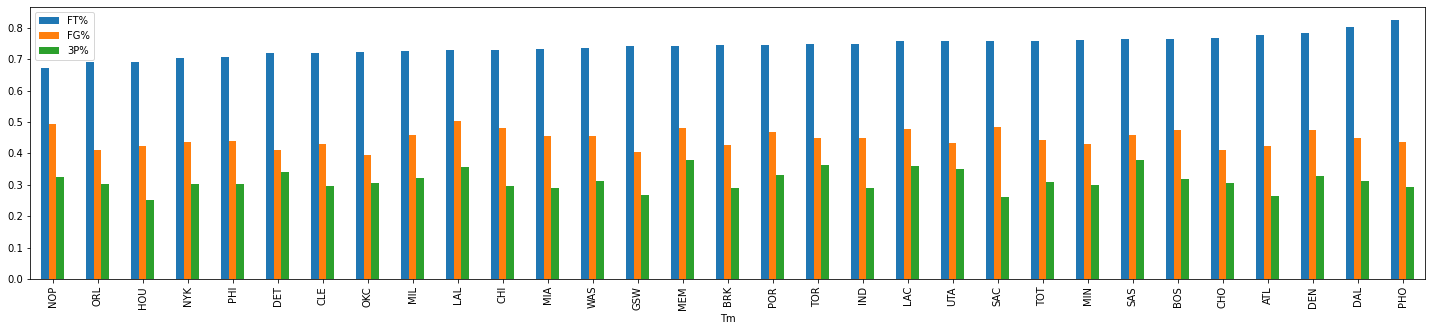

In [4]:
hs = ds[['Tm', 'FT%', 'FG%', '3P%']]
hs.groupby('Tm').mean().sort_values(['FT%'],ascending=True).plot(kind='bar', figsize=(25,5))

From first glimpse on our graph, it looks as if there isn't a direct correlation between 3-point % or Field Goal % to 3P%
But now I wonder - is there a relationship between between the number of 3-point shots taken to the precentage made? Let's check it per player, rather than per team

I think I am going to try and scatter-plot all values of each player average 3 pointers attempts vs 3 point made - resulting in the 3P% of that same player.

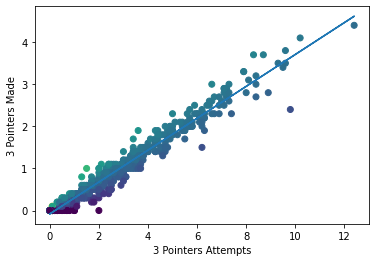

 LINE IS y = 0.379x -0.08


In [5]:
x, y = ds['3PA'], ds['3P']
m, b = np.polyfit(x, y, 1)

#add linear regression line to scatterplot 
plt.plot(x, m*x + b)
plt.scatter(x, y, c = ds['3P%'])
plt.xlabel("3 Pointers Attempts")
plt.ylabel("3 Pointers Made")
plt.show()
print(" LINE IS y = " + str(round(m, 3)) + "x " + str(round(b, 3)))

I notice some funny stuff from the graph, of which I will try to get more specific data.

0. How accurate is our curve? Based on the data's mean of 3P%?
1. Which player averages more than 12 3-pointer attempts per game?
2. Which players are above the curve (which marks the average percentage of 3 pointers percentage)? What is their position distribution? My assumption is that most people above curve are guards.

Average 3-Point Percentage is 0.312 with Standard Deviation of 0.128

198    James Harden
Name: Player, dtype: object



<AxesSubplot:>

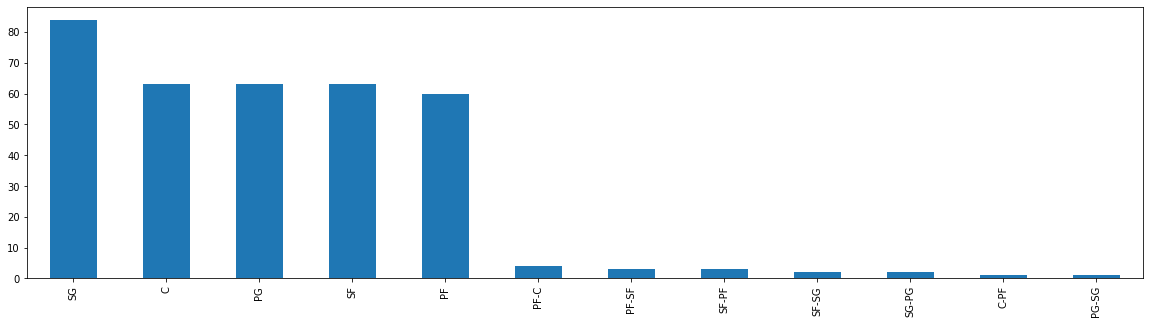

In [6]:
# ----------------- 0 ------------------
print("Average 3-Point Percentage is " + str(round(ds["3P%"].mean(), 3)) + " with Standard Deviation of " + str(round(ds["3P%"].std(), 3)))
print()
# ----------------- 1 ------------------
hs = ds[ds['3PA'] > 12]
print(hs['Player'])
print()
# ----------------- 2 ------------------
hs = ds[ds['3P%'] >= ds['3P%'].mean()]
ps = hs[['Player', 'Pos']]
ps['Pos'].value_counts().plot(kind='bar',figsize=(20,5))


We notice that our assumption was correct. Players playing in position of Shooting Guards are shotting above average 3-pointers

### Next: 

Previous we checked if there is a correlation in each team between the stats of free throws and 3-pointers. Looking back at it, it was wrong since each team is diverse in skills. A better analysis would be to do it by player and see if players with better 3-pointer % have better FT%. We can use scatter plot for this again.

Let's scatter each player's 3-pointer percerntage vs. FT% to see that.

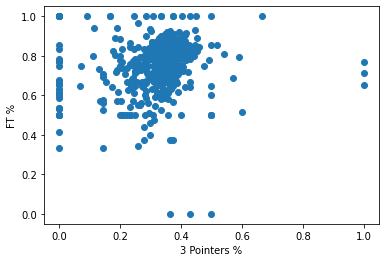

array([[<AxesSubplot:xlabel='ORB', ylabel='ORB'>,
        <AxesSubplot:xlabel='DRB', ylabel='ORB'>,
        <AxesSubplot:xlabel='TOV', ylabel='ORB'>,
        <AxesSubplot:xlabel='PF', ylabel='ORB'>,
        <AxesSubplot:xlabel='BLK', ylabel='ORB'>],
       [<AxesSubplot:xlabel='ORB', ylabel='DRB'>,
        <AxesSubplot:xlabel='DRB', ylabel='DRB'>,
        <AxesSubplot:xlabel='TOV', ylabel='DRB'>,
        <AxesSubplot:xlabel='PF', ylabel='DRB'>,
        <AxesSubplot:xlabel='BLK', ylabel='DRB'>],
       [<AxesSubplot:xlabel='ORB', ylabel='TOV'>,
        <AxesSubplot:xlabel='DRB', ylabel='TOV'>,
        <AxesSubplot:xlabel='TOV', ylabel='TOV'>,
        <AxesSubplot:xlabel='PF', ylabel='TOV'>,
        <AxesSubplot:xlabel='BLK', ylabel='TOV'>],
       [<AxesSubplot:xlabel='ORB', ylabel='PF'>,
        <AxesSubplot:xlabel='DRB', ylabel='PF'>,
        <AxesSubplot:xlabel='TOV', ylabel='PF'>,
        <AxesSubplot:xlabel='PF', ylabel='PF'>,
        <AxesSubplot:xlabel='BLK', ylabel='PF'>],
     

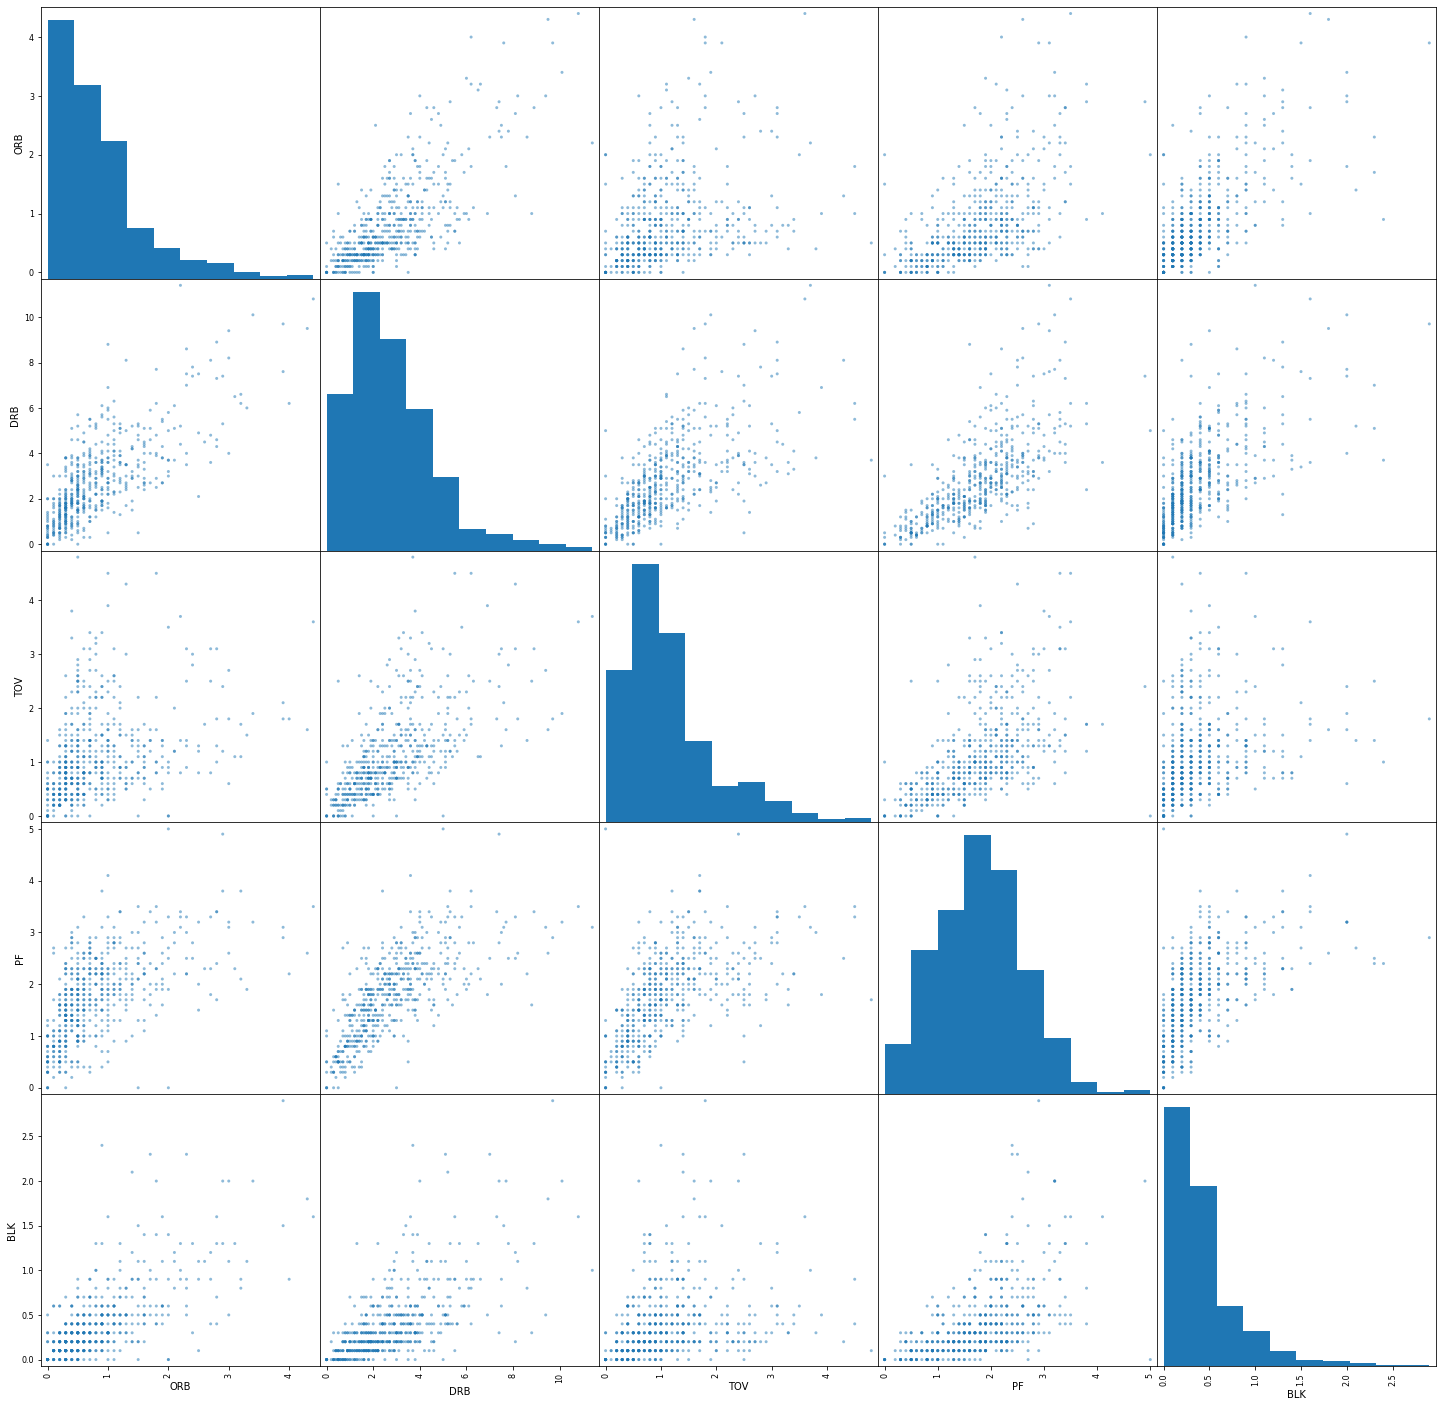

In [97]:
cs = ds[['3P%', 'FT%']]
x, y = ds['3P%'], ds['FT%']
plt.scatter(x, y)
plt.xlabel("3 Pointers %")
plt.ylabel("FT %")
plt.show()
pd.plotting.scatter_matrix(ds[['ORB', 'DRB', 'TOV', 'PF', 'BLK']], figsize = (25, 25))

It seems as if most players fall within one cluster. Let's go ahead and try to find the anomalies.
to find anomalies the best method that comes to my mind is an Isolation Forrest.

Each player after we run the proper algorithm will recieve an anomaly score which will allow us to see which players follow the least the trend and relationship between FT% to 3P%.

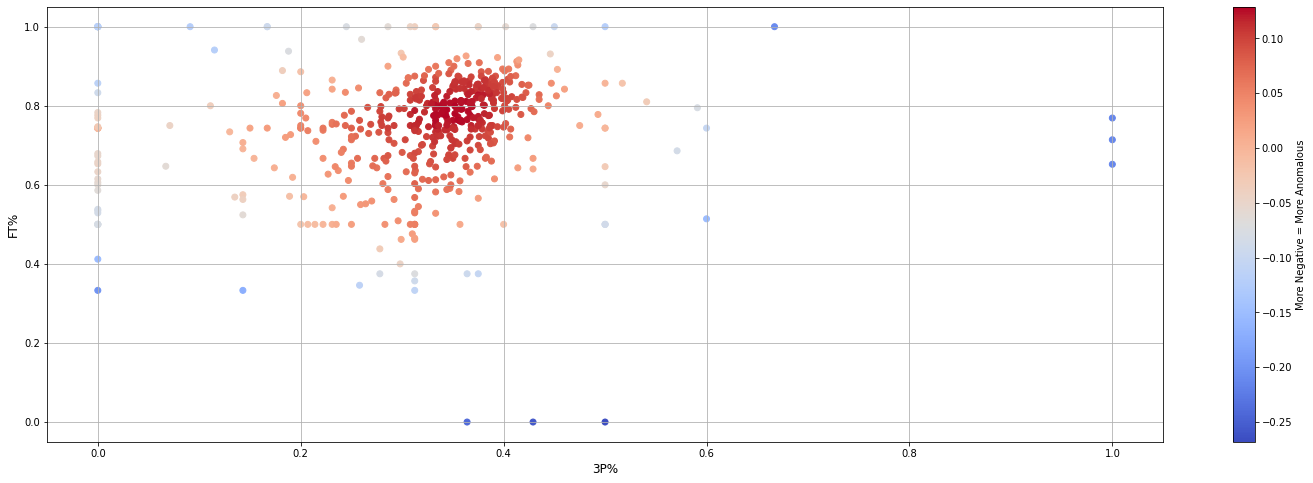

In [8]:
model = ensemble.IsolationForest().fit(cs)
# Get Anomaly Scores and Predictions
anomaly_score = model.decision_function(cs)
predictions = model.predict(cs)
######### Visualize Anomaly scores and Anomaly Status ########
plt.figure(figsize = (25, 8))
s = plt.scatter(cs['3P%'], cs['FT%'], c = anomaly_score, cmap = 'coolwarm')
plt.colorbar(s, label = 'More Negative = More Anomalous')
plt.xlabel('3P%', fontsize = 12)
plt.ylabel('FT%', fontsize = 12)
plt.grid()


In [9]:
anomaly_players = []
for i in range(len(ds)):
    if anomaly_score[i] < 0:
        anomaly_players.append([ds['Player'][i], round(anomaly_score[i], 4)])

ds_ap = pd.DataFrame(anomaly_players, columns =['Player', 'AnoScore']) #anomaly players ds
ds_ap = ds_ap.sort_values('AnoScore')
ds_ap.head(10)

,Player,AnoScore
101,Dean Wade,-0.2681
74,Jeremy Pargo,-0.2577
51,Louis King,-0.2414
26,Drew Eubanks,-0.2150
7,Tony Bradley,-0.2127
67,Johnathan Motley,-0.2125
36,Dusty Hannahs,-0.2091
9,Corey Brewer,-0.2010
53,Vic Law,-0.1697
3,Thanasis Antetokounmpo,-0.1544


I can continue and analyze those general statistics based on players' total and career-long statstics, but I think it would be more useful if I had a greater variety within my data, such as general statistics of each player through each year per game versus anyteam... etc. I could potentially predict various statstics prior to any game based on anomaly detection and trend recognition. Let's see if I can find a cool API for any of that.


I found this GitHub open source repository that alows me to pull in data from every game based on a game ID (accessible via table based on date) 
- Documentation: https://github.com/swar/nba_api/blob/master/docs/nba_api/live/endpoints/playbyplay.md
- Endpoints: https://cdn.nba.com/static/json/liveData/playbyplay/playbyplay_{GAME_ID}.json

#### Update:
Succesfully contructed "retrieve_02.py" file to retreieve action data from 1080 games. Games info and dates are stored properly in "games.csv"

#### Update:
Combined both retrieve scripts into one for the sake of open source so people seeing this later will have easier time running the script without complications. Datasets now:
- players.csv includes general information about all NBA players and career statistics
- actions.csv includes every action from 1080 games from the 2020 - 2021 season. Will use it to analyze and predicy player behavior in upcoming games


### Next:
now that we have the wanted data, let's analyze it. Let's begin with something easy such as 

In [46]:
ds = pd.read_csv('actions.csv')
print(ds.columns)
print(list(set(ds['actionType'])))

Index(['Unnamed: 0', 'actionNumber', 'clock', 'timeActual', 'period',
       'periodType', 'actionType', 'subType', 'qualifiers', 'personId', 'x',
       'y', 'possession', 'scoreHome', 'scoreAway', 'edited', 'orderNumber',
       'xLegacy', 'yLegacy', 'isFieldGoal', 'side', 'description',
       'personIdsFilter', 'teamId', 'teamTricode', 'descriptor',
       'jumpBallRecoveredName', 'jumpBallWonPlayerName', 'jumpBallWonPersonId',
       'jumpBallLostPlayerName', 'jumpBallLostPersonId', 'officialId',
       'turnoverTotal', 'playerName', 'playerNameI', 'foulPersonalTotal',
       'foulTechnicalTotal', 'foulDrawnPlayerName', 'foulDrawnPersonId',
       'shotResult', 'pointsTotal', 'shotDistance', 'assistPlayerNameInitial',
       'assistPersonId', 'assistTotal', 'shotActionNumber', 'reboundTotal',
       'reboundDefensiveTotal', 'reboundOffensiveTotal', 'blockPlayerName',
       'blockPersonId', 'jumpBallRecoverdPersonId', 'stealPlayerName',
       'stealPersonId', 'game_id', 'game_dat

Let's begin with some easy stuff:
- Which player has the most steals in this season?
- Which player has the most blocks in this season?
- Bar plot of all actions from the entire season - which action is most popular (my guess is FG)

<AxesSubplot:title={'center':'Leading 20 Players in Assists'}>

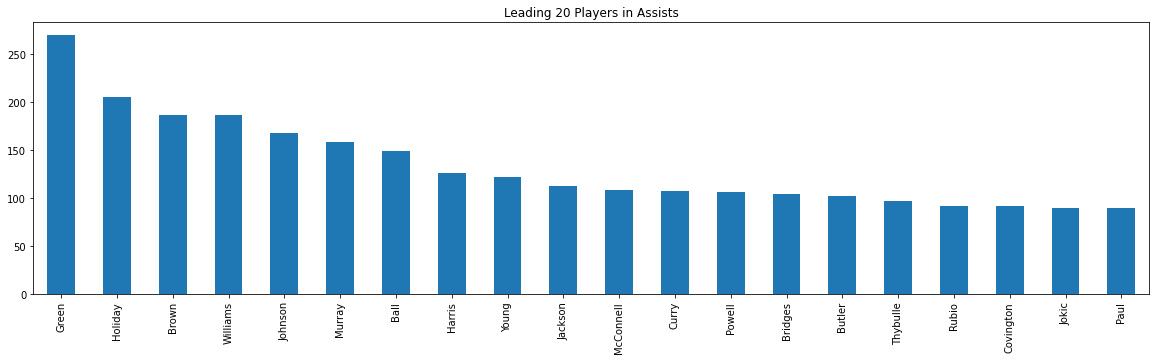

In [35]:
ds["stealPlayerName"].value_counts()[:20].plot(kind='bar',figsize=(20,5), title = "Leading 20 Players in Assists")

<AxesSubplot:title={'center':'Leading 20 Players in Blocks'}>

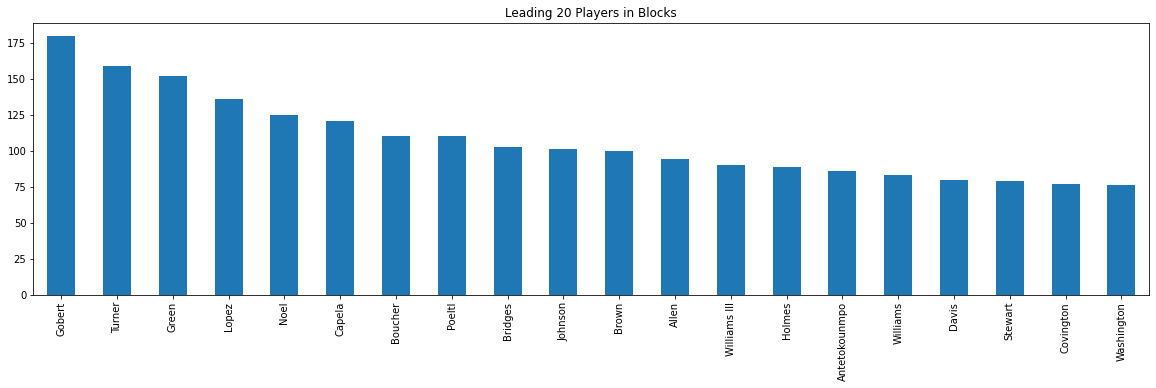

In [34]:
ds["blockPlayerName"].value_counts()[:20].plot(kind='bar',figsize=(20,5), title = "Leading 20 Players in Blocks")

<AxesSubplot:title={'center':'Most Common Actions Per Game'}>

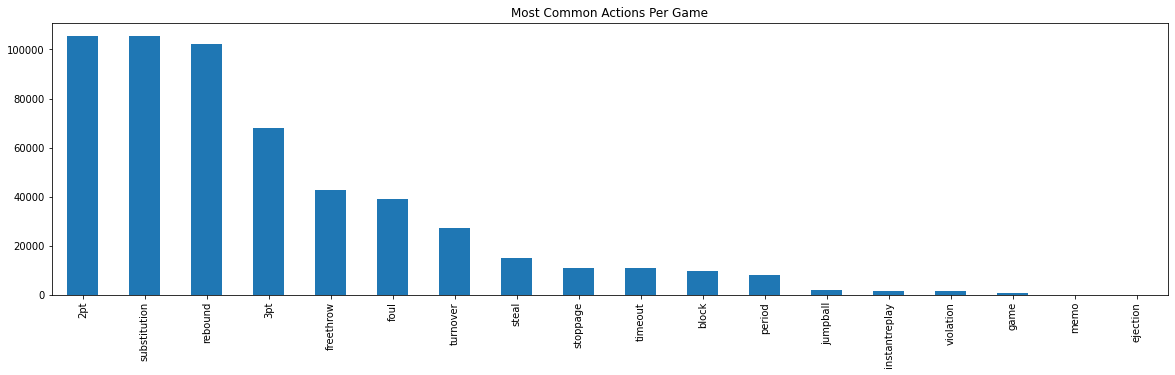

In [33]:
ds["actionType"].value_counts().plot(kind='bar',figsize=(20,5), title = "Most Common Actions Per Game")

### Next:
Let's try to scatter plot some stuff. I think it would be cool to see at what time in the game most 3 pointers will be made. And, now that we have access to all game action data we can actually graph it

In [76]:
# ths = ds[['actionType', 'clock']]
# ths = ths[ths['actionType'] == '3pt']
# # ths.dropna(subset=['pointsTotal'], inplace = True, how = 'any')
# ths['clock'] = ths['clock'].str[2:4] + ths['clock'].str[5:7]
# ths["clock"].value_counts().plot(kind='bar',figsize=(20,5), title = "Most Common Actions Per Game", xticks = 12)

<AxesSubplot:title={'center':'Most Jump Balls Won By Player (top 30)'}>

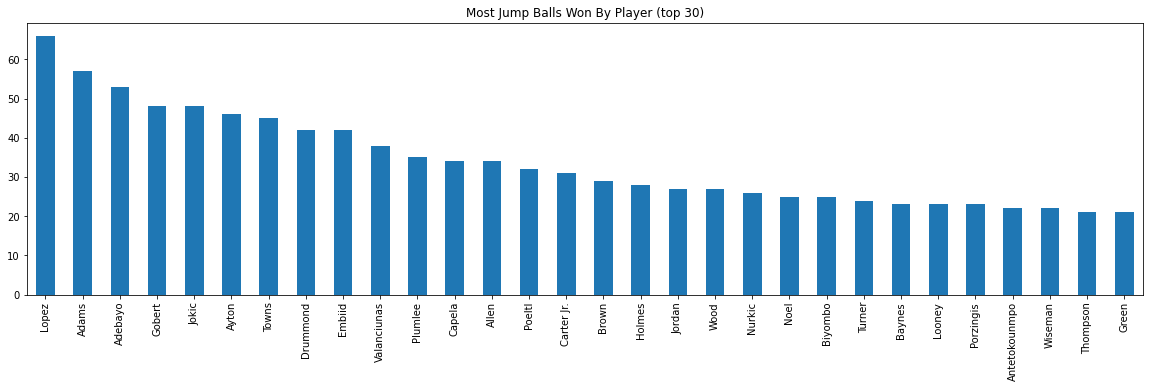

In [80]:
jbs = ds[['jumpBallWonPlayerName', 'jumpBallLostPlayerName']]
jbs['jumpBallWonPlayerName'].value_counts()[:30].plot(kind = 'bar', figsize = (20, 5), title = 'Most Jump Balls Won By Player (top 30)')

<AxesSubplot:title={'center':'Most Jump Balls Lost By Player (top 30)'}>

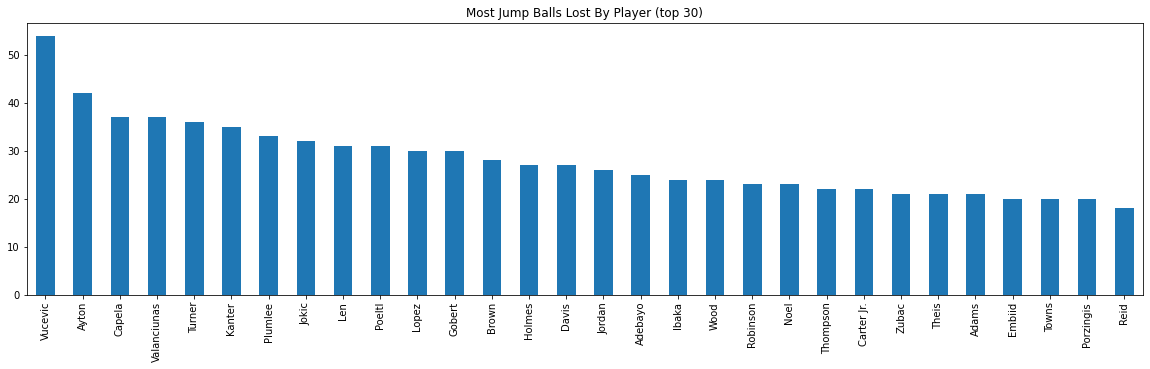

In [81]:
jbs['jumpBallLostPlayerName'].value_counts()[:30].plot(kind = 'bar', figsize = (20, 5), title = 'Most Jump Balls Lost By Player (top 30)')

### Continue: (June 14, 2022):

Last  night I showed this to some freshmen who came to watch the game (Celtics v. Warriors) last night with my roommate.
First and foremost - Warriors won. Huge for me hahaha JP and Wiggins were THRIVING. Though Steph had 0-9 threes we still brought home the W and are looking to win the series in 6.

Nonetheless, our guest was kinda impressed with everything I showed him. I actually thought the coolest thing I had here is the anomaly detection algorithm for players and their relation between 3P% and FT%. I wanted to see if I can find other similar relationships in players stats, so I am gonna do just that

I thought about it for a bit and I think it'd be cool to see the relationship between Minute Played (MP) and a player's Field Goal percentage. Would players who play longer have higher percentage in making field goals? Let's find out

By the way, I think I'd avoid using Isolation Forrests here just because I want to use a different anomaly detection method for the sake of good practice and software developerment ability diversity.

Column Player didn't work because its vartype doesn't have a mean
Column Pos didn't work because its vartype doesn't have a mean
Column Tm didn't work because its vartype doesn't have a mean


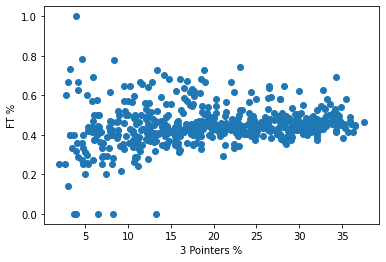

In [4]:
players = pd.read_csv('players.csv')  
for i in players.columns:
    try:
        players[i].fillna(value=players[i].mean(), inplace=True)
    except:
        print("Column " + i + " didn't work because its vartype doesn't have a mean")

x, y = players['MP'], ds['FG%']
plt.scatter(x, y)
plt.xlabel("3 Pointers %")
plt.ylabel("FT %")
plt.show()

<ipython-input-54-30612c9acab2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  players_ocsvm_ad['Predicted'] = model_predictions


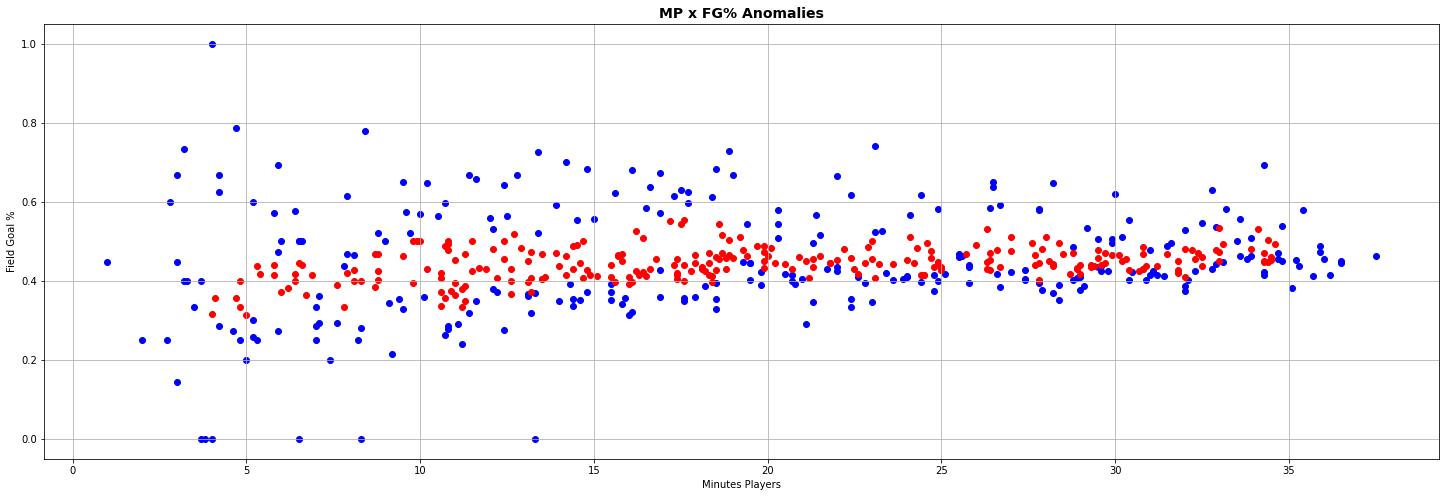

In [54]:
players_ocsvm_ad = players[["MP", "FG%"]] #OCSVM_AD = One Class Support Vector Machine Anomaly Detection

model = svm.OneClassSVM(kernel='rbf', gamma = 1).fit(players_ocsvm_ad)
model_predictions = model.predict(players_ocsvm_ad)
players_ocsvm_ad['Predicted'] = model_predictions
players_ocsvm_ad
# Make Scatterplot
norms = pd.DataFrame(players_ocsvm_ad[players_ocsvm_ad['Predicted'] == -1])
anoms = pd.DataFrame(players_ocsvm_ad[players_ocsvm_ad['Predicted'] == 1])

plt.figure(figsize = (25, 8))
plt.scatter([norms['MP']], [norms['FG%']], color = 'b')
plt.scatter([anoms['MP']], [anoms['FG%']], color = 'r')
plt.title('MP x FG% Anomalies', weight = 'bold', fontsize = 14)
plt.xlabel('Minutes Players')
plt.ylabel('Field Goal %')
plt.grid()

Results seem pretty good, as the anomalies are colored clearly disgtiguishly from the regular points.
Let's go ahead and compare the results to other anomaly detection methods (Isolation Forest, Robust CoVariance, LocalOutlier Factor)

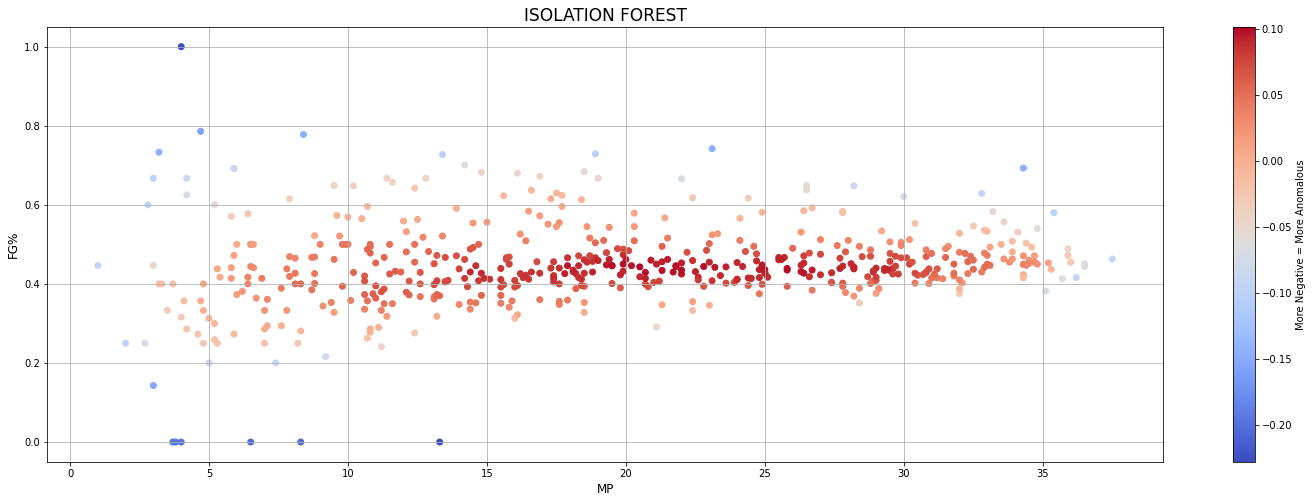

In [55]:
players_ocsvm_ad = players[["MP", "FG%"]] #OCSVM_AD = One Class Support Vector Machine Anomaly Detection

model = ensemble.IsolationForest().fit(players_ocsvm_ad)
# Get Anomaly Scores and Predictions
anomaly_score = model.decision_function(players_ocsvm_ad)
predictions = model.predict(players_ocsvm_ad)


# ----------------- VISUALIZE -------------------
plt.figure(figsize = (25, 8))
s = plt.scatter(players_ocsvm_ad['MP'], players_ocsvm_ad['FG%'], c = anomaly_score, cmap = 'coolwarm')
plt.colorbar(s, label = 'More Negative = More Anomalous')
plt.xlabel('MP', fontsize = 12)
plt.ylabel('FG%', fontsize = 12)
plt.title("ISOLATION FOREST", fontsize = 17)
plt.grid()

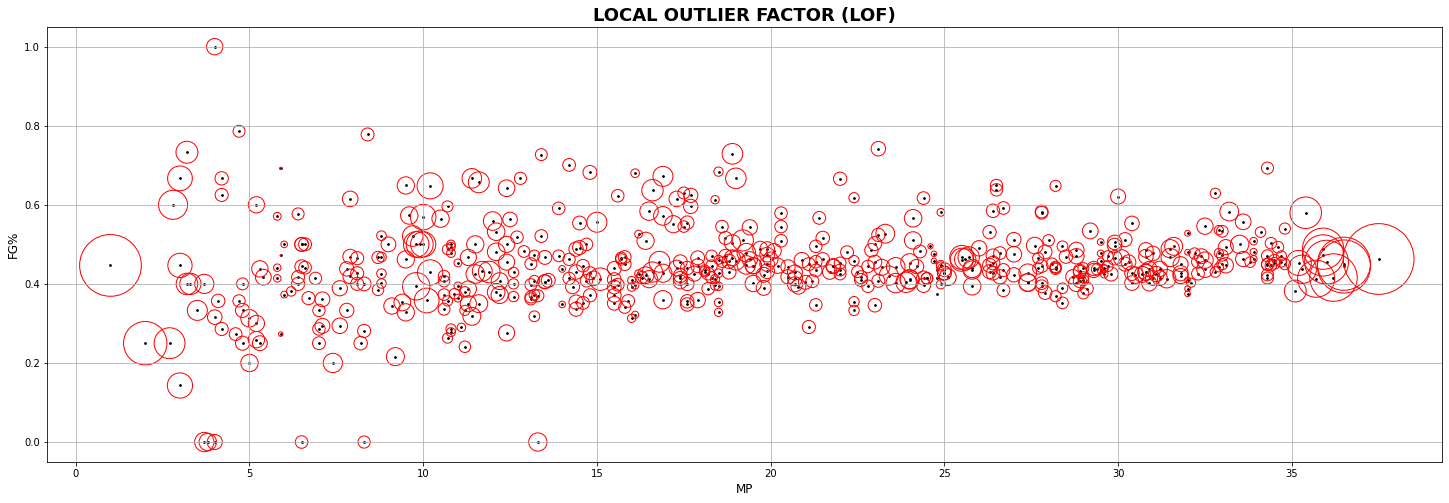

In [91]:
X = players[["MP", "FG%"]] 
clf = LocalOutlierFactor(n_neighbors = 20) #contamination parameter = control how many outliers are desired

predictions = clf.fit_predict(X)
ground_truth = [1] * len(X)
n_errors = (predictions != ground_truth).sum()
anomaly_scores = clf.negative_outlier_factor_

# plot circles with radius proportional to the outlier scores
radius = ((anomaly_scores.max() - anomaly_scores) / (anomaly_scores.max() - anomaly_scores.min())) * 5

# ----------------- VISUALIZE -------------------
plt.figure(figsize = (25, 8))
plt.title("LOCAL OUTLIER FACTOR (LOF)", fontsize = 18, weight = 'bold')
plt.scatter(X['MP'], X['FG%'], color = "k", s = 3.0, label="Data points")
plt.scatter( X['MP'], X['FG%'], s=1000 * radius, edgecolors="r", facecolors="none", label="Outlier scores")
plt.xlabel('MP', fontsize = 12)
plt.ylabel('FG%', fontsize = 12)
# plt.xlabel("prediction errors: %d" % (n_errors))
plt.grid()
# resource : https://scikit-learn.org/stable/auto_examples/neighbors/plot_lof_outlier_detection.html#:~:text=The%20Local%20Outlier%20Factor%20(LOF,lower%20density%20than%20their%20neighbors.

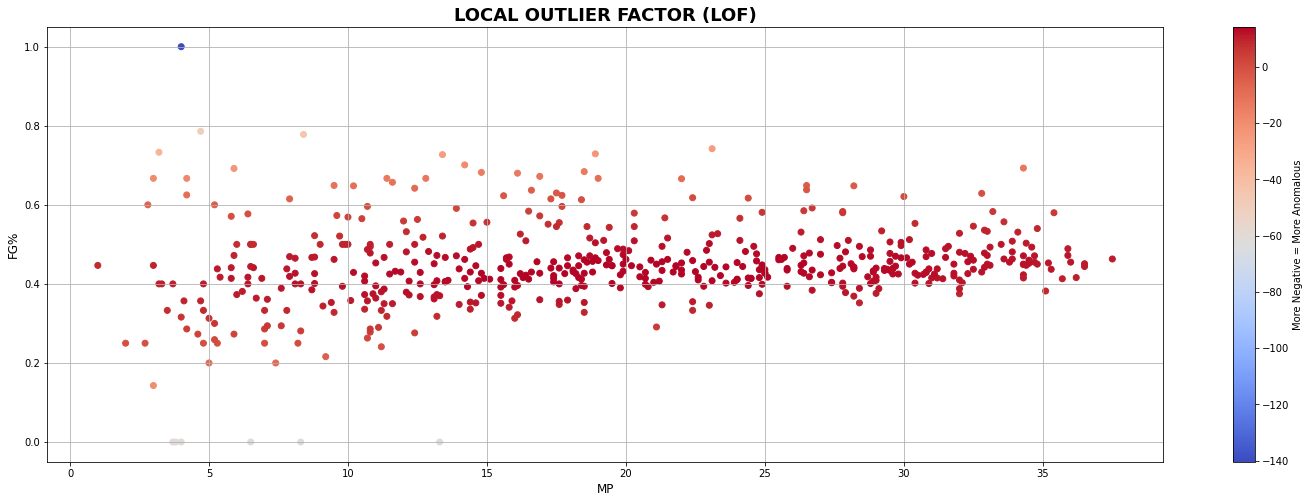

In [98]:
X = players[["MP", "FG%"]] 
model = EllipticEnvelope()

model.fit(X)
anomaly_scores = model.decision_function(X)
predictions = model.predict(X)

# ----------------- VISUALIZE -------------------
plt.figure(figsize = (25, 8))
plt.title("LOCAL OUTLIER FACTOR (LOF)", fontsize = 18, weight = 'bold')
s = plt.scatter(X['MP'], X['FG%'], c = anomaly_scores, cmap = 'coolwarm')
plt.colorbar(s, label = 'More Negative = More Anomalous')
plt.xlabel('MP', fontsize = 12)
plt.ylabel('FG%', fontsize = 12)

plt.grid()


Now that we have experienced a bit with anomaly detection ....

Let's try to see where do players shoot their shots from. Previous we discovered that James harden is the only player averaging more than 12 3pt attempts per game (let alone the fact that every other player averages less than 10). So let's try to see where does James harden takes his three pointers from.

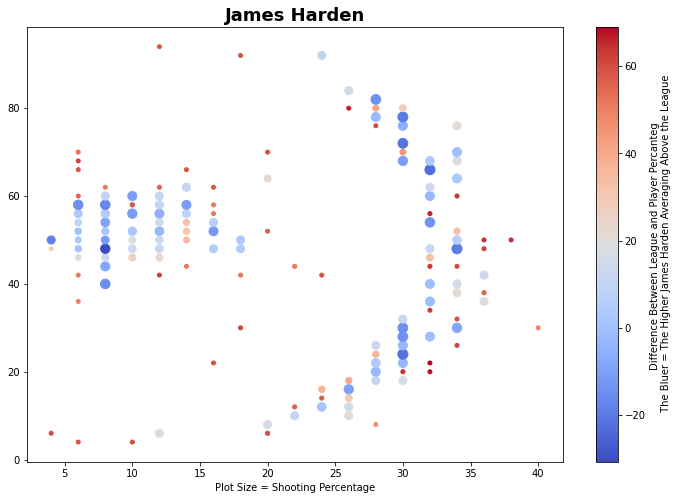

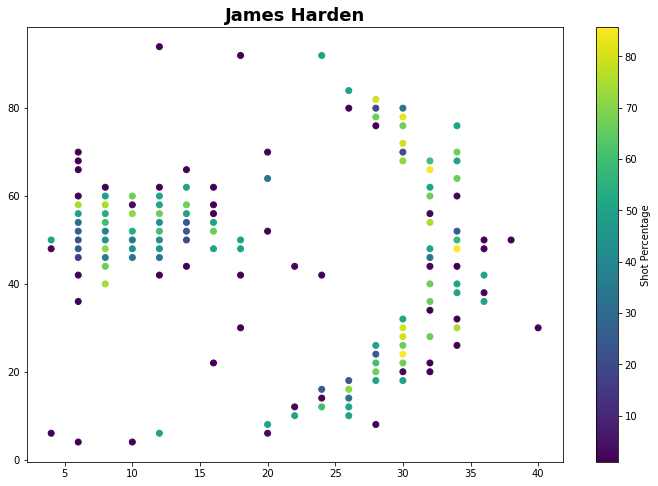

In [89]:
def minimizeGeoShots(x, base):
    return base * round(x/base)

def convertCourtOneSided(ds):
    for i, x, y in zip(ds.index, ds['x'], ds['y']):
        if x > 50:
            ds.loc[i , 'x'] = 100 - x
            ds.loc[i , 'y'] = 100 - y
    return ds

ds = pd.read_csv('actions.csv')
ds = ds[['actionType', 'x', 'y', 'playerName', 'shotResult']]
ds_ = ds.loc[(ds['actionType'].isin(['3pt', '2pt']))]
ds = ds.loc[(ds['actionType'].isin(['3pt', '2pt'])) & (ds['playerName'] == 'Harden')]

def calcXYshotAvg(ds):
    ds['x'], ds['y'] = list(map(lambda x: minimizeGeoShots(x, 2), ds['x'])), list(map(lambda x: minimizeGeoShots(x, 2), ds['y']))
    ds = convertCourtOneSided(ds)
    ds = ds.groupby(['x', 'y', 'shotResult'], as_index = False)['actionType'].count()
    ds.columns = ['x','y','result', 'count']
    ds_miss = ds[ds['result'] == 'Missed']
    ds = ds[ds['result'] == 'Made']
    ds.drop('result', axis = 1, inplace = True)
    for x, y, c in zip(ds_miss['x'], ds_miss['y'], ds_miss['count']):
        if ((ds['x'] == x) & (ds['y'] == y)).any():
            made, miss = ds[(ds['x'] == x) & (ds['y'] == y)]['count'], c
            ds.loc[(ds['x'] == x) & (ds['y'] == y), 'count'] = 100 - round((100 * (made / (made + miss))), 2)
        else:
            pd.concat([ds, pd.DataFrame([x, y, -c])], axis = 0, ignore_index = True)
    return ds

ds_ = calcXYshotAvg(ds_)
ds = calcXYshotAvg(ds)

ds['diffLg'] = [0] * len(ds) #create default column
# --- add column for difference between player and league average
for x, y, c in zip(ds_['x'], ds_['y'], ds_['count']):
    if ((ds['x'] == x) & (ds['y'] == y)).any():
        player, league = ds[(ds['x'] == x) & (ds['y'] == y)]['count'], c
        ds.loc[(ds['x'] == x) & (ds['y'] == y), 'diffLg'] = league - player
plt.figure(figsize = (12, 8))
plt.title("James Harden", fontsize = 18, weight = 'bold')
plt.xlabel('Plot Size = Shooting Percentage')
s = plt.scatter(ds['x'], ds['y'], s = 15 + (ds['count']), c = ds['diffLg'] , cmap = 'coolwarm', marker = 'o')
cbar = plt.colorbar(s, label = 'Difference Between League and Player Percanteg \n The Bluer = The Higher James Harden Averaging Above the League')
plt.show()

plt.figure(figsize = (12, 8))
plt.title("James Harden", fontsize = 18, weight = 'bold')
s = plt.scatter(ds['x'], ds['y'], c = ds['count'], cmap = 'viridis', marker = 'o')
cbar = plt.colorbar(s, label = 'Shot Percentage')
plt.show()

In [ ]:
## ----- END CODE BLOCK ----------------

import json 
with open("analyze.ipynb", mode = "r", encoding="utf-8") as f:
    myfile = json.loads(f.read())

with open("../../../src/blocks/jsons/nba.json", "w+") as f:
    json.dump(myfile, f)